In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import folium
from sum_money import *
%load_ext autoreload
%autoreload 2

# Amount of money received per canton

The functions used in this notebook are implemented in amount_sum.py file.

## Load P3 data

In [2]:
# load cantons dictionnary from JSON file
with open('data/cantons.json', 'r') as ff:
    cantons = json.load(ff)
    
# load df DataFrame of P3 database
df = pd.read_csv('data/P3_GrantExport.csv', header=0, sep=';')
df = df.fillna('')

## Clean P3 data

In [3]:
# Remove the `fail` entry
del cantons['fail']

# Deal the strange value in `Approved Amount` field
df.loc[df['Approved Amount'] == 'data not included in P3', 'Approved Amount'] = 0
# Convert `Approved Amount` to float type
df['Approved Amount']= df['Approved Amount'].astype(float)


## Assign total amount assigned to each canton

The function `sum_by_canton` if found in sum_money.py

In [4]:
from collections import defaultdict

# create a dictionary with canton name and the assigned amount
canton_money = dict()
for i in cantons:
    money = sum_by_canton(df, cantons, i)
    canton_money[i] = int(money)

# deal with missing canton (ie the ones that doesn't receive any money)
# default dictionnary
canton_money = defaultdict(lambda: 0, canton_money)

# Map Vizualization

** Convert ch-canton.topojson to GeoJson** using [jeffpaine.github.io/geojson-topojson](http://jeffpaine.github.io/geojson-topojson/)

In [5]:
# load GeoJson of swiss canton
canton_topo = json.load(open('data/ch-canton.geojson.json'))

In [6]:
import folium.colormap as cm

# prepare color line for canton between min and max amount of money
min_ = 0
max_ = max(canton_money.items(), key=lambda a: a[1])[1]

step = cm.StepColormap(['white', 'red', 'yellow','greenyellow', 'green'],
                       vmin=0, vmax=4000000000, index=[0,3, 1000000000,2000000000, 3000000000, 4000000000],
                       caption='step')

step

In [7]:
m = folium.Map([46.9,8.4], tiles='cartodbpositron', zoom_start=8)

folium.GeoJson(
    canton_topo,
        style_function=lambda feature: {
        'fillColor': step(canton_money[feature['id']]),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(m)

colormap = step
colormap.caption = 'Amount of money assigned for research project'
m.add_child(colormap)

m.save(os.path.join('results', 'ch_map.html'))

m

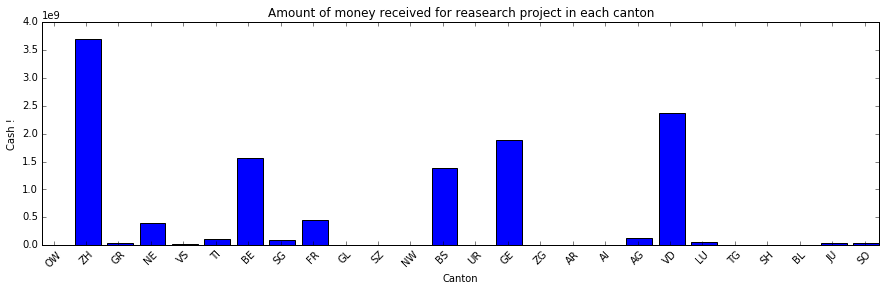

In [8]:
plot_dict(canton_money, 'Amount of money received for reasearch project in each canton', 'Canton', 'Cash !')

## Rösti- and Polentagraben

In [9]:
swiss_french = ['FR', 'NE', 'VS', 'VD', 'JU', 'GE']
swiss_italien = ['TI']
swiss_german = [i for i in list(canton_money.keys()) if i not in (swiss_french + swiss_italien)]

region_money = dict()
region_money['les_welsches'] = sum_by_region(df, canton_money, swiss_french)
region_money['les_bourbines'] = sum_by_region(df, canton_money, swiss_german)
region_money['les_ticinesi'] = sum_by_region(df, canton_money, swiss_italien)
region_money['les_rumantsch'] = 0


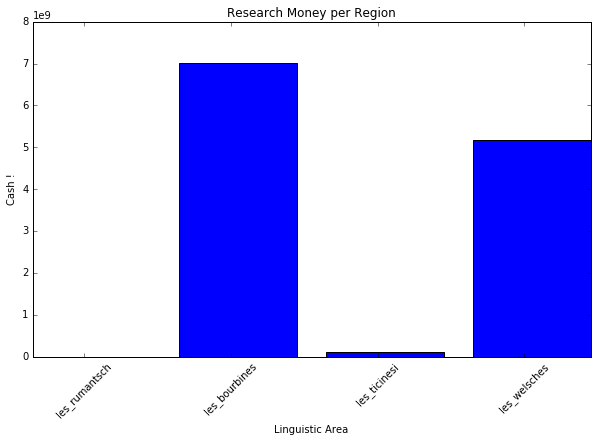

In [10]:
plot_dict(region_money, "Research Money per Region", "Linguistic Area", "Cash !", (10, 6))

Based on this graph we cannot state that there are big differences between Swiss-French and Swiss-German in terms of research investments. At the opposite, if we look at the size of the population in each part, we will probably conclude that there is more investment per person in the Swiss-French part.

I will not comment on the situation of Ticino and Graubünden.